# Client Retention Demo Using PySpark

In this demo, we will show PySpark functionality accessing enterprise data from VSAM and DB2. The data stored in VSAM consists of 6001 rows of customer information. The data stored in DB2 consists of 20,000 rows of transaction data. The data is transformed and joined within a Spark dataframe, which is used to perform predictive analyses. A logistic regression algorithm is then used to evaluate cutomer activity level vs. churn.

SparkSession is the entry point to using Spark on z/OS APIs through IBM Open Data Analytics for z/OS (IzODA).

In [4]:
import sys
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

zOS_IP = "123.456.78.901"
MDSS_PORT = "1200"
zOS_USERNAME = "???????"
zOS_PASSWORD = "????????"

spark = SparkSession.builder.master("spark://<Your Analytics Instance IP Address>:7077").appName("pyspark_demo").getOrCreate()

***Client Data***

Load client data into a Spark dataframe.

In [6]:
jdbc_connection = "jdbc:rs:dv://"+zOS_IP+":"+MDSS_PORT+"; DBTY=DVS; SUBSYS=NONE; UID="+zOS_USERNAME+"; PWD="+zOS_PASSWORD+";"
raw_clientInfo_df = spark.read \
        .format("jdbc") \
        .option("url", jdbc_connection) \
        .option("dbtable", "VSAM_CLIENT") \
        .load()
clientInfo_df = raw_clientInfo_df. \
    toDF("customer_id","gender","age_years","highest_edu","annual_investment_rev","annual_income","activity_level","churn", "rid"). \
    select("customer_id","gender","age_years","highest_edu","annual_investment_rev","annual_income","activity_level","churn")
        
clientInfo_df.show(10)

+-----------+------+---------+-----------+---------------------+-------------+--------------+-----+
|customer_id|gender|age_years|highest_edu|annual_investment_rev|annual_income|activity_level|churn|
+-----------+------+---------+-----------+---------------------+-------------+--------------+-----+
| 1009520370|     1|    63.23|          4|                0.000|    13035.000|             3|    0|
| 1009520380|     1|    58.51|          1|                0.000|    18267.000|             0|    0|
| 1009520390|     0|    31.10|          2|           111192.000|   129276.000|             2|    0|
| 1009520400|     0|    49.84|          1|                0.000|    17867.000|             2|    0|
| 1009520410|     1|    53.33|          1|                0.000|    17576.000|             1|    0|
| 1009520420|     1|    47.72|          3|            90419.000|   111569.000|             5|    0|
| 1009520430|     0|    48.46|          2|            11258.000|    20142.000|             1|    1|


***Credit card transactions***

Load credit card transactions into a Spark dataframe.

In [7]:
DB2_SSID = "DBBG"
jdbc_connection = "jdbc:rs:dv://"+zOS_IP+":"+MDSS_PORT+"; DBTY=DB2; SUBSYS="+DB2_SSID+"; UID="+zOS_USERNAME+"; PWD="+zOS_PASSWORD+";"
clientTrans_df = spark.read \
        .format("jdbc") \
        .option("url", jdbc_connection) \
        .option("dbtable", "sparkdb.sppaytb1") \
        .load()
clientTrans_df.show(10)

+--------------------+-------------------------+-------------------------+--------------------------+-------------------------+----------------------------+-----------------------------+--------------------------+----------+------------------+---+------------------+----------------+
|  ACAUREQ_HDR_CREDTT|ACAUREQ_AUREQ_ENV_A_ID_ID|ACAUREQ_AUREQ_ENV_M_ID_ID|ACAUREQ_AUREQ_ENV_M_CMONNM|ACAUREQ_AUREQ_ENV_CPL_PAN|ACAUREQ_AUREQ_ENV_C_CARDBRND|ACAUREQ_AUREQ_TX_MRCHNTCTGYCD|ACAUREQ_AUREQ_TX_DT_TTLAMT|   CONT_ID|MDM_POSTAL_CODE_ID|AGE|AUTHORRESULT_RSPNT|FRAUD_VER_RESULT|
+--------------------+-------------------------+-------------------------+--------------------------+-------------------------+----------------------------+-----------------------------+--------------------------+----------+------------------+---+------------------+----------------+
|2013-04-03T00:47:...|            BancaItaliana|        C0120580917273555|            Don't be alone|               1009549375|                   Vi

## Aggregate statistics
Calculate a few aggregate statistics based on credit transactions and join the results to the client data dataframe. We also convert some of the fields to integer and double type, which will be used in following calculations.

In [8]:
import pyspark.sql.functions as func

calcTrans_df = clientTrans_df.groupBy("CONT_ID").agg(func.sum("ACAUREQ_AUREQ_TX_DT_TTLAMT"), \
func.count("ACAUREQ_AUREQ_TX_DT_TTLAMT")/365, \
func.count("ACAUREQ_AUREQ_TX_DT_TTLAMT"), \
func.sum("ACAUREQ_AUREQ_TX_DT_TTLAMT")/func.count("ACAUREQ_AUREQ_TX_DT_TTLAMT"))

schema = StructType([ \
    StructField("CONT_ID", IntegerType()), \
    StructField("total_txn_amount", DoubleType()), \
    StructField("avg_daily_txns", DoubleType()), \
    StructField("total_txns", IntegerType()), \
    StructField("avg_txn_amount", DoubleType()) \
    ])
    
calcTrans_df = calcTrans_df.toDF('CONT_ID', 'total_txn_amount', 'avg_daily_txns', 'total_txns', 'avg_txn_amount')
calcTrans_df.show(10)

+----------+------------------+------------------+----------+------------------+
|   CONT_ID|  total_txn_amount|    avg_daily_txns|total_txns|    avg_txn_amount|
+----------+------------------+------------------+----------+------------------+
|1009550400|           40688.1|0.8054794520547945|       294|138.39489795918368|
|1009551830| 8939.620000000003| 0.663013698630137|       242|36.940578512396705|
|1009551650| 6646.009999999994|0.6575342465753424|       240|27.691708333333306|
|1009549280| 8085.619999999999|0.3780821917808219|       138| 58.59144927536231|
|1009555320|2051.8500000000004|0.1232876712328767|        45| 45.59666666666668|
|1009526940| 6733.309999999996|0.6575342465753424|       240|28.055458333333316|
|1009527300|16870.380000000005|0.6575342465753424|       240| 70.29325000000001|
|1009548170| 9762.529999999997|0.7041095890410959|       257|37.986498054474694|
|1009532800|18049.940000000002|0.5342465753424658|       195| 92.56379487179488|
|1009528570|           7926.

In [9]:
client_df = clientInfo_df.join(calcTrans_df, calcTrans_df.CONT_ID == clientInfo_df.customer_id, "inner")
client_df.show(10)

+-----------+------+---------+-----------+---------------------+-------------+--------------+-----+----------+------------------+------------------+----------+------------------+
|customer_id|gender|age_years|highest_edu|annual_investment_rev|annual_income|activity_level|churn|   CONT_ID|  total_txn_amount|    avg_daily_txns|total_txns|    avg_txn_amount|
+-----------+------+---------+-----------+---------------------+-------------+--------------+-----+----------+------------------+------------------+----------+------------------+
| 1009550400|     0|    74.09|          3|            96792.000|   199469.000|             5|    0|1009550400|           40688.1|0.8054794520547945|       294|138.39489795918368|
| 1009551830|     1|    30.06|          4|                0.000|    20592.000|             2|    0|1009551830| 8939.620000000003| 0.663013698630137|       242|36.940578512396705|
| 1009551650|     0|    71.09|          1|                0.000|    13415.000|             5|    0|100955

## Predictive Analyses

We now start to do some predictive analyses on the data to evaluate cutomer activity level vs. churn. We use a supervised learning algorithm, logistic regression, to train the model. Logistic regression is a common, fast, highly scalable, classification model that doesn't require much tuning and is easy to regularize. The model outputs a set of probabilities which can be more useful than class labels. Here, we will use PySpark Machine Learning library to create our model.

In [10]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula
from pyspark.sql.functions import udf

input_df = client_df
formula = RFormula().setFormula("churn ~ activity_level").setFeaturesCol("features").setLabelCol("label")
train_df = formula.fit(input_df).transform(input_df).select("label", "features")

model =  LogisticRegression().setThreshold(0.5)
result_df = model.fit(train_df).transform(train_df)

result_df.show()

+-----+--------+--------------------+--------------------+----------+
|label|features|       rawPrediction|         probability|prediction|
+-----+--------+--------------------+--------------------+----------+
|  0.0|   [5.0]|[3.85984010823379...|[0.97936347150229...|       0.0|
|  0.0|   [2.0]|[0.92715396815165...|[0.71649753078297...|       0.0|
|  0.0|   [5.0]|[3.85984010823379...|[0.97936347150229...|       0.0|
|  1.0|   [3.0]|[1.90471601484570...|[0.87042435495748...|       0.0|
|  0.0|   [4.0]|[2.88227806153975...|[0.94696339290452...|       0.0|
|  1.0|   [1.0]|[-0.0504080785423...|[0.48740064813728...|       1.0|
|  1.0|   [2.0]|[0.92715396815165...|[0.71649753078297...|       0.0|
|  1.0|   [1.0]|[-0.0504080785423...|[0.48740064813728...|       1.0|
|  0.0|   [5.0]|[3.85984010823379...|[0.97936347150229...|       0.0|
|  0.0|   [2.0]|[0.92715396815165...|[0.71649753078297...|       0.0|
|  0.0|   [5.0]|[3.85984010823379...|[0.97936347150229...|       0.0|
|  1.0|   [0.0]|[-1.

Now, we plot the S-curve for cutomer activity level vs. churn. Matplotlib and Seaborn are two common plotting libraries used in Python. These plotting libraries are useful in creating custom visualizations to help gain insights from our data.

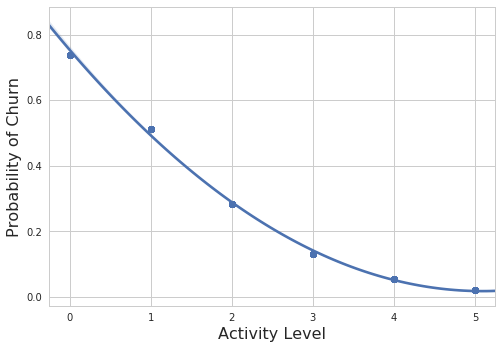

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid")

plot_list = [(e['features'].item(0),1-e['probability'].item(0)) for e in result_df.collect()]
X = [plot_pair[0] for plot_pair in plot_list]
Y = [plot_pair[1] for plot_pair in plot_list]

plt.figure()
plt.xlabel("Activity Level", fontsize=16)
plt.ylabel("Probability of Churn", fontsize=16)
sns.regplot(x=np.array(X),y=np.array(Y), order=2)
plt.show()